In [1]:
## 利用 LSTM 做一个 Seq2Seq 的预测，不考虑准确性

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229_sc.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset.insert(1, 'future2',dataset.future)
dataset['future2'] = dataset['future'].shift(-1)
dataset = dataset.fillna(0)

# print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的
TEST_BATCH_COUNT = 1
Y_DIM = 2                                                         # 要用2个y来表示预测的第一天和预测的第二天，对应 "future" 和 "future2",每个y都是1-D的，y的seq_len是2
X_DIM = dataset.shape[1]-Y_DIM                                    # 表示输入的sequence里每个element有122维度，也是encoder的input_dim

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, X_DIM+Y_DIM)                   # 数据一共是 seq_count x seq_len x (x_in_dim+y_dim) 

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch


print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LENGTH, X_DIM+Y_DIM)  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - TEST_BATCH_COUNT
test_batch_count = TEST_BATCH_COUNT

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,Y_DIM:], train[:,:,-1:,0:Y_DIM]           # [train_batch_count, batch_size, sequence_length, XorY dimission]
test_x,  test_y  = test[:,:,:, Y_DIM:],  test[:,:,-1:,0:Y_DIM]           # [train_batch_count, batch_size, sequence_length, XorY dimission]

train_y = train_y.permute(0, 1, 3, 2)                                    # conver from [train_batch_count, batch_size, seq_length, y-dim]  to [train_batch_count, batch_size, y-sequence_length, 1 dim]
test_y  =  test_y.permute(0, 1, 3, 2)                                    # conver from [test_batch_count, batch_size, seq_length, y-dim]  to [test_batch_count, batch_size, y-sequence_length, 1 dim]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

rolling_data shape: (441, 60, 124)
seq count: 441
seq length: 60
total batch count: 441
batch size: 1
rolling_data: torch.Size([441, 1, 60, 124])
train_x: torch.Size([440, 1, 60, 122])
train_y: torch.Size([440, 1, 2, 1])
test_x:  torch.Size([1, 1, 60, 122])
test_y:  torch.Size([1, 1, 2, 1])
train_batch_count: 440
test_batch_count:  1


In [26]:
# Define the Encoder & Decoder class

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        # print("Encoder self.input_dim  : {}".format(self.input_dim))
        # print("Encoder self.hidden_dim  : {}".format(self.hidden_dim))
    
    def forward(self, x):
        # print("Encoder forward() x: {}".format(x.shape))
        outputs, (h_n, c_n) = self.lstm(x)
        # print("Encoder outputs :{}".format(outputs.shape))
        # print("Encoder h_n     :{}".format(h_n.shape))
        # print("Encoder c_n     :{}".format(c_n.shape))
        return outputs, h_n, c_n

    
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        
        self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        # input : input batch data, size(input): [batch_size, feature_size]
        # notice input only has two dimensions since the input is batchs
        # of last coordinate of observed trajectory so the sequence length has been removed.
        
        # add sequence dimension to input, to allow use of nn.LSTM
        # print("Decoder forward() input size : {}".format(input.shape))
        # print("Decoder forward() hidden size: {}".format(hidden.shape))
        # print("Decoder forward() cell size  : {}".format(cell.shape))
        
        input = self.fc_in(input)

        lstm_output, (hidden, cell) = self.lstm(input, (hidden, cell))
        
        # print("Decoder forward() lstm_output: {}".format(lstm_output.shape))
        
        prediction = self.fc_out(lstm_output)         # prediction is [batch_size, output_dim]
        
        return prediction, hidden, cell
    
 

In [43]:
# Define the model class

ENC_INPUT_DIM   = X_DIM
ENC_HIDDEN_DIM  = 768
DEC_INPUT_DIM   = 1
DEC_HIDDEN_DIM  = 768
DEC_OUPUT_DIM   = 1
NUM_LAYERS      = 1
ENC_DROPOUT     = 0.1
DEC_DROPOUT     = 0.1
DEC_OUTPUT_LEN  = 2


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        self.decoder_fc_init= nn.Linear(encoder.input_dim, decoder.input_dim)
        # self.decoder_fc_input= nn.Linear(decoder.output_dim, decoder.input_dim)
        
        assert (encoder.hidden_dim == decoder.hidden_dim), "hidden dimension in encoder and decoder must be equal"       
        assert (encoder.num_layers == decoder.num_layers), "hidden layer numbers in encoder and decoder must be equal"
        
            
    def forward(self, x, y):
        # x is the input to the encoder.
        # y is the output from the decoder
        # x = [batch size, encoder_in_sequence_len, encoder_in_dim]               encoder_in_sequence_len=45, encoder_in_dim=122
        # y = [batch size, encoder_in_sequence_len, decoder_out_dim]             decoder_out_sequence_len=45, decoder_out_dim=2
        
        # print("Seq2Seq forwar() x shape : {}".format(x.shape))
        # print("Seq2Seq forwar() y shape : {}".format(y.shape))
                
        batch_size = x.shape[0]
        encoder_in_seq_len = x.shape[1]
        encoder_in_dim = x.shape[2]
        
        decoder_out_seq_len = y.shape[1]                                                # This is most important that define the output length
        # decoder_out_dim = y.shape[2]
        
        # tensor to store decoder outputs of each time step
        # outputs = torch.zeros(batch_size, decoder_out_seq_len, DEC_OUPUT_DIM).double().to(device)
        outputs = torch.zeros(y.shape).to(device)
        # print("Seq2Seq forward() outputs shape: {}".format(outputs.shape))
        
        encoder_output, hidden, cell = self.encoder(x)
        # print("encoder_output shape: {}".format(encoder_output.shape))                    # [batch_size, encode_input_seq_length, encoder_hidden_dim]
        # print("encoder hidden shape: {}".format(hidden.shape))                            # [encoder_hidden_layer_number, batch_size, encoder_hidden_dim]
        # print("encoder cell shape :  {}".format(cell.shape))                              # [encoder_hidden_layer_number, batch_size, encoder_hidden_dim]
        

        # first input to decoder may be last coordinates of x to predict the future: [last_x] --> [model] --> [future_y]
        # this is last batch and last word of sequence.
        # print("Seq2Seq forward() x shape : {}".format(x.shape))                             # [batch_size, encode_input_seq_length, encoder_input_dim]
        # print("Seq2Seq forward() x[-1,-1,:] shape : {}".format(x[-1,-1,:].shape))           # [encoder_input_dim]
        decoder_input = x[:, -1, :]                                                           # [batch_size, encoder_input_dim] Get last element of sequence of the batch in encoder
        decoder_input = decoder_input.unsqueeze(1)                                            # [batch_size, 1, encoder_input_dim] Get last element of sequence of the batch in encoder
        # print("decoder_input: {}".format(decoder_input.shape))
        decoder_input = self.decoder_fc_init(decoder_input)                                   # [batch_size, 1, decoder_input_dim] Conver to 1st element of sequence of the batch in decoder
        
        # decoder_input = torch.zeros(self.decoder.input_dim).double().to(device)
        
        # decoder_input = torch.zeros(batch_size, seq_len, OUPUT_DIM).double().to(device)
        # print("Seq2Seq forward() encoder_output shape : {}".format(encoder_output.shape))
        
        # print("Seq2Seq forward() decoder_input shape: {}".format(decoder_input.shape))
        # decoder_input = decoder_input.unsqueeze(0)
        # decoder_input = decoder_input.unsqueeze(0)
        # print("Seq2Seq forward() decoder_input shape: {}".format(decoder_input.shape))

        
        # Becasue the input and target have different sequence length
        # Get the target prediction one by one
        for i in range(decoder_out_seq_len):
            # run the decoder for one time step
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            # print("Seq2Seq forward() output shape: {}".format(output.shape))

            # place predictions in a tensor holding predictions for each time step
            outputs[:,i,:] = output
            # print("Seq2Seq forward() outputs shape: {}".format(outputs.shape))            
            # output is the same shape as input, [batch_size, feature size]
            # so we can use output directly as next input
            decoder_input = output
            # print("Seq2Seq forward() decoder_input shape: {}".format(output.shape))
            
            # 或者使用teacher_forcing来优化
            # teacher_forcing_ratio=0.5
            # teacher_force = random.random() < teacher_forcing_ratio
            # decoder_input = y[i] if teacher_forcing else output
        return outputs
        

In [44]:
# 实例化模型
encoder = Encoder(input_dim=ENC_INPUT_DIM, hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=ENC_DROPOUT)
decoder = Decoder(input_dim=DEC_INPUT_DIM, hidden_dim=DEC_HIDDEN_DIM, num_layers=NUM_LAYERS, output_dim=DEC_OUPUT_DIM, dropout=DEC_DROPOUT)

model = Seq2Seq(encoder, decoder).double().to(device)


In [45]:
# 训练 Seq2Seq 模型; 
LR = 1e-4
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1)


model.train()
epoches = 10
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step], train_y[step])
        
#         print("Train pred shape : {}".format(pred.shape))
#         print("Train train_y[step] shape : {}".format(train_y[step].shape))
        
        loss = loss_func(pred, train_y[step].float())                                  # this calc the last element's loss between prediction and real.
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        epoch_loss += loss.data.cpu()

    print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, epoch_loss))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    
    # if (epoch+1)%40 == 0:
    #     scheduler.step()

0 of 10 epoch loss: 4.546502
1 of 10 epoch loss: 1.791893
2 of 10 epoch loss: 1.620879
3 of 10 epoch loss: 1.549675
4 of 10 epoch loss: 1.495712
5 of 10 epoch loss: 1.427790
6 of 10 epoch loss: 1.439167
7 of 10 epoch loss: 1.434969
8 of 10 epoch loss: 1.381002
9 of 10 epoch loss: 1.345864


Prediction Loss average:0.000000
Prediction: tensor([[[-0.0113],
         [-0.0135]]], device='cuda:0', grad_fn=<CopySlices>) ---- Actual: tensor([[[-0.1300],
         [ 0.0000]]], device='cuda:0', dtype=torch.float64)


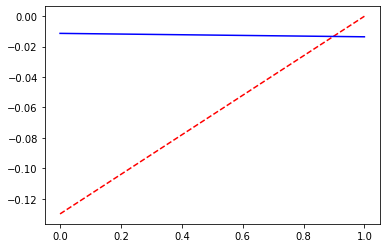

In [48]:
# 用模型预测数据
model.eval()
test_loss = 0

for step in range(test_batch_count):
    pred = model(test_x[step], test_y[step])

    loss = loss_func(pred, test_y[step])
    
    if (step+1) < test_batch_count:                       # 最后一个测试数据不需要统计，因为没有真实值。
        test_loss += loss.cpu()
    
    if test_batch_count == 1:
        print("Prediction Loss average:{:.6f}".format(test_loss/test_batch_count))
    else:
        print("Prediction Loss average:{:.6f}".format(test_loss/(test_batch_count-1)))
        
    print("Prediction: {} ---- Actual: {}".format(pred, test_y[step]))

actual_line = test_y[step].cpu().detach().flatten().numpy()
pred_line   = pred.cpu().detach().flatten().numpy()
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()

